# Analysis Notebook

In [1]:
MODEL_PATH = 'models/best_model.pt'
SEED = 1
DEVICE = 'cpu'

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
device = torch.device(DEVICE)
from main import ConvNet

np.random.seed(SEED)
torch.manual_seed(SEED)

# Sklearn stuff
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.manifold import TSNE

# Plotting for 7.c

,sixteenth,eighth,quarter,half,full
train_loss,0.068028,0.043260,0.029463,0.018189,0.005586
train_acc,0.979867,0.987483,0.991600,0.995233,0.998500
test_loss,0.060229,0.037765,0.030815,0.024652,0.020920
test_acc,0.981500,0.987900,0.989800,0.992500,0.993200


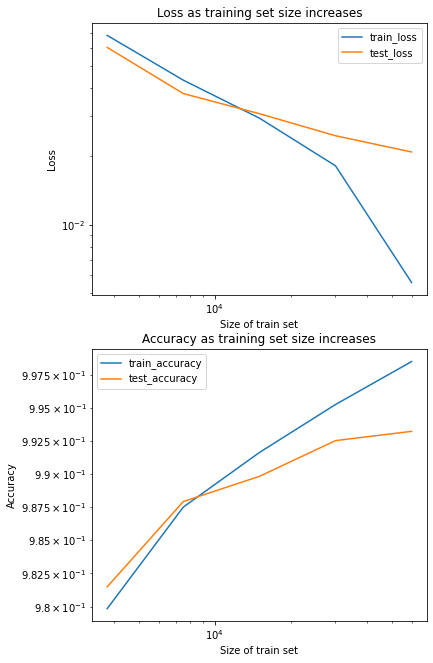

In [11]:
import pandas as pd

df = pd.read_json('train_subset.json')
df.index = ['train_loss', 'train_acc', 'test_loss', 'test_acc']

n = len(train_dataset) 
sizes = [n // 16, n // 8, n // 4, n // 2, n]
amounts = ['sixteenth', 'eighth', 'quarter', 'half', 'full']
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(6, 11))

ax0.plot(sizes, df.loc['train_loss', amounts], label='train_loss')
ax0.plot(sizes, df.loc['test_loss', amounts], label='test_loss')
ax0.legend(); ax0.set_xlabel('Size of train set'); ax0.set_ylabel('Loss')
ax0.set_xscale('log'); ax0.set_yscale('log')
ax0.set_title('Loss as training set size increases')


ax1.plot(sizes, df.loc['train_acc', amounts], label='train_accuracy')
ax1.plot(sizes, df.loc['test_acc', amounts], label='test_accuracy')
ax1.legend(); ax1.set_xlabel('Size of train set'); ax1.set_ylabel('Accuracy')
ax1.set_xscale('log'); ax1.set_yscale('log');
ax1.set_title('Accuracy as training set size increases');
plt.savefig('plots/subset_sizes.png')

df

#### Analysis:
These graphs show that as the size of the train set increases, the training and test loss both go down, while the train and test accuracy both go up. This is to be expected, of course. Whats more interesting is the rates at which this happens. From beginning to end, there's a roughly ten-fold increase in amount of training data, with a roughly 3-fold decrease in test loss (0.06 to 0.02). Thus we re-derive the rule of thumb Professor Perona mentioned about 10x data is 1/3x test loss.

### Load the Model and Data

In [2]:
transform_lst = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Pytorch has default MNIST dataloader which loads data at each iteration
train_dataset = datasets.MNIST('../data', train=True, download=True,
                                transform=transform_lst)
test_dataset = datasets.MNIST('../data', train=False,
                    transform=transform_lst)

    
assert os.path.exists(MODEL_PATH)

# Set the test model
model = ConvNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

### Make a new model that returns the embedding (before the final linear layer)

In [3]:
class EmbeddingNet(ConvNet):
    def __init__(self, original_model=None):
        super(EmbeddingNet, self).__init__()
        if original_model is not None:
            self.load_state_dict(model.state_dict())
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        return self.fc1(x)

emb_net = EmbeddingNet(model)
emb_net.eval();

### Compute predictions and embeddings

In [4]:
# Set some sizes
n_train = len(train_dataset)
n_test = len(test_dataset)
fc_weights = emb_net.state_dict()['fc1.weight']
embed_size = fc_weights.shape[0]


def get_preds_embs_labels(dataset, n, embed_size=embed_size):
    preds = np.empty(n, dtype=int)
    labels = np.empty(n, dtype=int)
    embeddings = np.empty((n, embed_size))
    for i, (x, label) in enumerate(test_dataset):
        out1 = emb_net(x.reshape(1, *x.shape))[0]
        out2 = model(x.reshape(1, *x.shape))[0]
        embeddings[i] = out1.detach().numpy()
        preds[i] = np.argmax(out2.detach().numpy())
        labels[i] = label
    return preds, embeddings, labels
        
test_preds, test_embs, test_labels = get_preds_embs_labels(test_dataset, n_test)
train_preds, train_embs, train_labels = get_preds_embs_labels(train_dataset, n_train)

### Analysis

#### 8.b

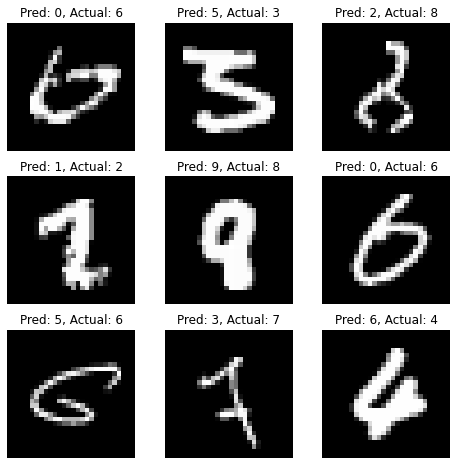

In [5]:
bad_inds = np.where(test_preds != test_labels)[0]
chosen_inds = bad_inds[:9] 
#chosen_inds = np.random.choice(bad_inds, 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for idx, ax in zip(chosen_inds, axes.flatten()):
    ax.axis('off')
    ax.imshow(test_dataset.data[idx].detach().numpy(), cmap='gray')
    ax.set_title(f'Pred: {test_preds[idx]}, Actual: {test_labels[idx]}')
plt.savefig('plots/misses.png')

#### Analysis:
Each of the mistakes shown above are very reasonable. The top left has a very short tail for a 6 and can easily be mistaken for a 0, the top center looks a lot like a 5 as well as a 3, etc. In general, all of the mistakes above are on images that a human would probably correctly label, but would definitely be uncertain about as compared to regular digits which are usually more identifiable. Thus, the fact the model is getting these poorly written / barely discernible images wrong is not surprising.

#### 8.c

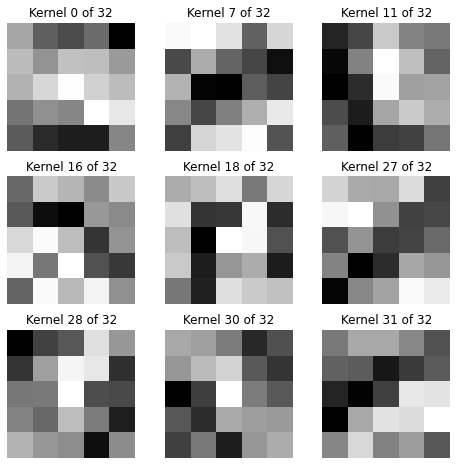

In [6]:
n_kernels = 9;
kernels = model.state_dict()['conv1.weight'].squeeze()
chosen_inds = [
    0, 7,   # Bright in middle rows / upper-lower rows resp.
    11,     # Bright right side
    16,     # Bright bottom left
    18,     # Cool spiral pattern
    27, 28, # Dark / Bright off diag resp.
    30,     # Bright along on diag.
    31      # Bottom right triangle bright
]
#chosen_inds = np.random.choice(range(len(kernels)), n_kernels, replace=False)

fig, axes = plt.subplots(3, n_kernels // 3, figsize=(8, 8))
for idx, ax in zip(chosen_inds, axes.flatten()):
    ax.axis('off')
    ax.imshow(kernels[idx].detach().numpy(), cmap='gray')
    ax.set_title(f'Kernel {idx} of {len(kernels)}')
plt.savefig('plots/kernels.png')

#### Analysis:
These kernels are not as clearly line / edge detectors as some kernels in models like AlexNet. However, they are still interesting. In particular, as annotated in the code above, Kernels 0 and 7 seem to have light / dark pixels in their middle rows respectively, suggesting they might be used to find lines or holes in numbers. Kernel 11 has a bright side on the right, while kernel 16 has a bright bottom left corner, suggesting these kernels are useful in identifying certain regions in images also. See the code comments in the cell above for more details, but all the kernels seem to be useful in picking up on certain features in our images, though these features are not as concrete as one might expect. (Part of my reasoning here is that the kernels are only 5 x 5, so bigger convolution kernels might have more obvious features they pick up on).

#### 8.d

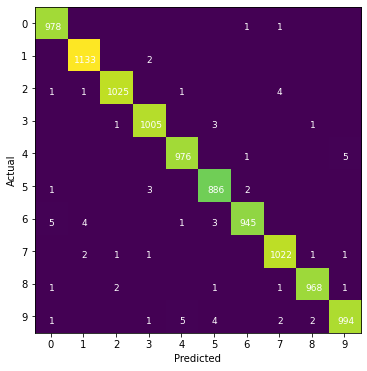

In [7]:
mat = confusion_matrix(test_labels, test_preds)

def plot_confusions(grid, axis = None):
    """ Utility to neatly plot confusions matrix. """
    ax = axis if axis else plt.subplot(111)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.grid(False)
    ax.set_xticks(np.arange(grid.shape[0]))
    ax.set_yticks(np.arange(grid.shape[0]))
    ax.imshow(grid, interpolation='nearest');

    for i, cas in enumerate(grid):
        for j, count in enumerate(cas):
            if count > 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
    return ax
                

plt.gcf().set_size_inches(6, 6)
plot_confusions(mat)
plt.savefig('plots/confusions.png')

#### Analysis:
The confusion matrix demonstrates first that our model is really good! It's also interesting to note that the digits that are often confused with one another by the model are digits that are very similar in nature. Looking just at where 5's appear (the highest number in our matrix), we can see that 0 and 6, and 4 and 9, are the most mixed up. As demonstrated in 8.b, 0's and 6s, when poorly written (the tail on the 6 is short), look very similar. Also, it is easy to see that if the top lines in a 4 end up close together, this might look like a circle / make the number look like a 9. Thus, our confusions matrix confirms the results of 8.b, which is that the inaccuracies are coming from hard to discern numbers also.

#### 8.e.1

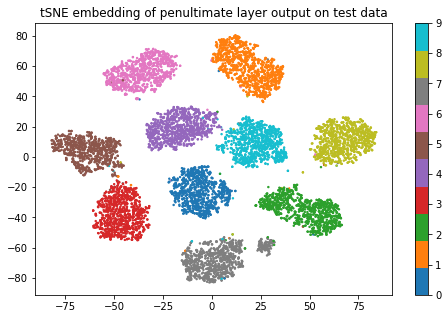

In [8]:
perp = 30.0
path = f'tsne_{perp}.pkl'

# This takes a while, so we'll just load from pickle
if not os.path.exists(path):
    #tsne = TSNE(n_components=2, perplexity=perp)
    #X_tsne = tsne.fit_transform(test_embs)
    with open(path, 'wb') as f:
        pickle.dump(X_tsne, f)

with open(path, 'rb') as f:
    X_tsne = pickle.load(f)
    
cmap = plt.get_cmap('tab10', 10)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_labels, s=2, cmap=cmap)
plt.title('tSNE embedding of penultimate layer output on test data')
plt.gcf().set_size_inches(8, 5)
plt.colorbar();
plt.savefig('plots/tSNE.png')

#### Analysis:
The tSNE shows that the embeddings before the final layer are already very segregated by label, meaning the final perceptron layer would have an easy time separating the data cleanly. We can see a distinct cluster for each label in 2D space, with numbers that are similar having clusters closer together (e.g. 4 and 9, 5 and 3). Also, the erroneous points (images that ended up with the wrong label) are likely the points in the wrong clusters shown above (there are a few 9s that wound up in the 4 cluster, etc). Thus, this tSNE diagram shows similar things as 8.d and 8.b, namely that our model doesn't get a lot wrong, and the things it does get wrong are reasonable.

#### 8.e.2

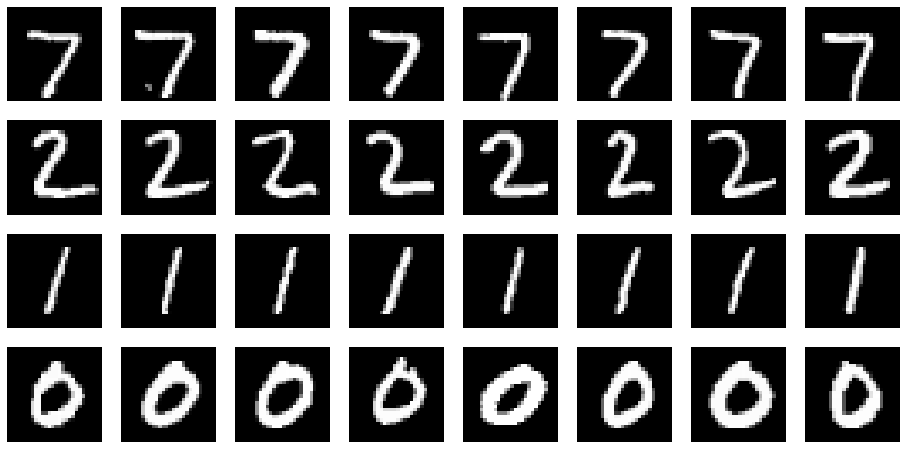

In [9]:
n_close = 8
inds = [0, 1, 2, 3]

D = pairwise_distances(test_embs)

fig, axes = plt.subplots(len(inds), n_close, figsize=(n_close * 2, 8))

for idx, ax_row in zip(inds, axes):
    close_inds = np.argsort(D[idx])[:n_close]
    for i, ax in zip(close_inds, ax_row):
        ax.axis('off')
        ax.imshow(test_dataset.data[i].detach().numpy(), cmap='gray')
        
plt.savefig('plots/close_ims.png')

#### Analysis:
This figure above shows that points close in embedding (128 dimensional) space are images that are very very similar to one another. In particular, the 8 closest neighbors to the point $x_0$ are always images showing the same digit as $I_0$, and furthermore, are almost identical images to $I_0$. There are many ways of drawing 1 (with the little hat / base, for example), but all the images in row 3 of the figure above are of 1's drawn the exact same way; as a slightly sloping vertical line. Thus, we can see that images similar to one another end up close in embedding space.